<h2 style='text-align:center;'>StudentScoreAI 🎓</h2>
<p style='text-align:center;'><em>Forecasting Student Performance with Machine Learning</em></p>

This end-to-end notebook loads student study-hours data, performs EDA, cleans the data, trains and evaluates regression models, and exports the best model for a Flask app. It is written to be recruiter-friendly with clear narration and professional code comments.


### Imports & Setup
We keep imports minimal and standard. We also define paths relative to the repo so this notebook runs on any machine.

In [1]:
# Core imports
import warnings; warnings.filterwarnings('ignore')  # keep output clean in the notebook
from pathlib import Path                         # robust file paths
import json                                      # save metrics to disk

import numpy as np                                # numerical computing
import pandas as pd                               # dataframes
import matplotlib.pyplot as plt                   # plotting (no seaborn as per style)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib                                     # model persistence

# Paths (repo-relative)
BASE_DIR = Path.cwd().resolve()
DATA_PATH = (BASE_DIR / '../data/student_info.csv').resolve()
APP_MODEL_PATH = (BASE_DIR / '../app/student_mark_prediction.pkl').resolve()
RESULTS_DIR = (BASE_DIR / '../results').resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH, APP_MODEL_PATH, RESULTS_DIR  # ➤ quick sanity check of paths

(WindowsPath('C:/Users/MUBASSHIR/OneDrive/Desktop/FSDS_TASKS/Machine_Learning/ML_Projects/01_StudentScoreAI/data/student_info.csv'),
 WindowsPath('C:/Users/MUBASSHIR/OneDrive/Desktop/FSDS_TASKS/Machine_Learning/ML_Projects/01_StudentScoreAI/app/student_mark_prediction.pkl'),
 WindowsPath('C:/Users/MUBASSHIR/OneDrive/Desktop/FSDS_TASKS/Machine_Learning/ML_Projects/01_StudentScoreAI/results'))

### Load Dataset
We load `student_info.csv`. If there are accidental blanks or non-numeric values, we coerce and handle them.

In [2]:
# Read CSV (expects columns: study_hours, student_marks)
df = pd.read_csv(DATA_PATH)

# Ensure correct dtypes; coerce invalid values to NaN so we can drop them cleanly
df['study_hours'] = pd.to_numeric(df['study_hours'], errors='coerce')
df['student_marks'] = pd.to_numeric(df['student_marks'], errors='coerce')

# Basic overview
display(df.head())                               # ➤ first rows
print('Shape:', df.shape)                        # ➤ shape
display(df.describe(include='all'))              # ➤ summary
print('Nulls\n', df.isnull().sum())             # ➤ null counts

,study_hours,student_marks
0,6.83,78.50
1,6.56,76.74
2,NaN,78.68
3,5.67,71.82
4,8.67,84.19


Shape: (200, 2)


,study_hours,student_marks
count,195.000000,200.00000
mean,6.995949,77.93375
std,1.253060,4.92570
min,5.010000,68.57000
25%,5.775000,73.38500
50%,7.120000,77.71000
75%,8.085000,82.32000
max,8.990000,86.99000


Nulls
 study_hours      5
student_marks    0
dtype: int64


### Clean Data
For this small demo dataset, the most transparent approach is to **drop rows with missing values**. On larger datasets we would consider imputations (median/knn) and outlier checks.

In [3]:
df_clean = df.dropna().copy()
print('Rows removed due to NaN:', len(df) - len(df_clean))   # ➤ rows dropped
display(df_clean.head())

# Optional: simple sanity constraints (hours between 0 and 24; marks between 0 and 100)
df_clean = df_clean[(df_clean['study_hours'].between(0, 24)) & (df_clean['student_marks'].between(0, 100))].copy()
print('After constraint filtering, shape:', df_clean.shape)  # ➤ filtered shape

Rows removed due to NaN: 5


,study_hours,student_marks
0,6.83,78.50
1,6.56,76.74
3,5.67,71.82
4,8.67,84.19
5,7.55,81.18


After constraint filtering, shape: (195, 2)


### Exploratory Data Analysis (EDA)
Quick plots to understand distributions and relationships.

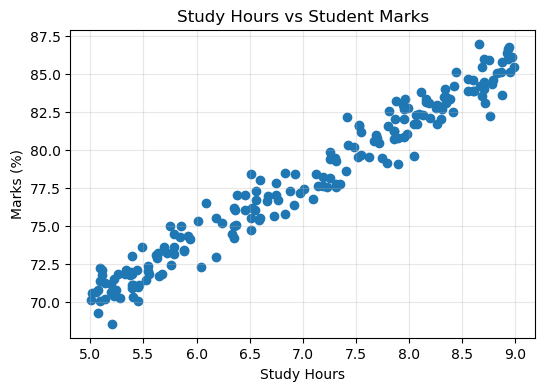

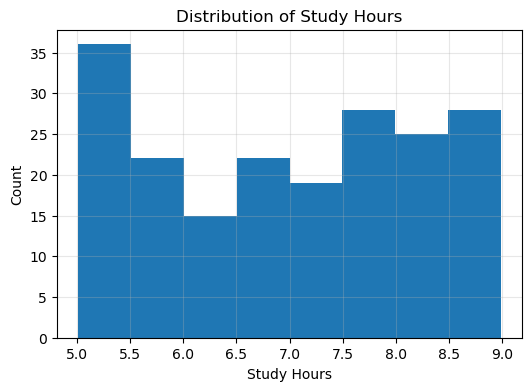

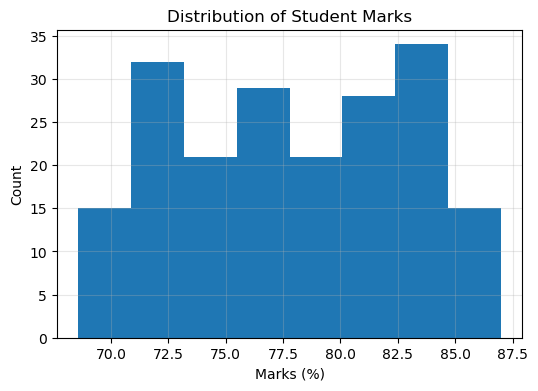

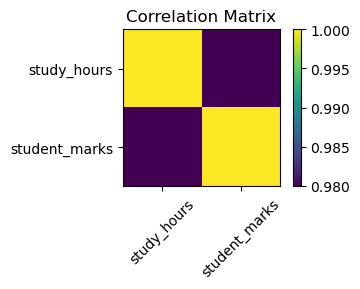

,study_hours,student_marks
study_hours,1.000000,0.979919
student_marks,0.979919,1.000000


In [4]:
# Scatter: study hours vs student marks
plt.figure(figsize=(6,4))
plt.scatter(df_clean['study_hours'], df_clean['student_marks'])
plt.title('Study Hours vs Student Marks')
plt.xlabel('Study Hours')
plt.ylabel('Marks (%)')
plt.grid(True, alpha=0.3)
plt.show()

# Histograms
plt.figure(figsize=(6,4))
plt.hist(df_clean['study_hours'], bins=8)
plt.title('Distribution of Study Hours')
plt.xlabel('Study Hours')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_clean['student_marks'], bins=8)
plt.title('Distribution of Student Marks')
plt.xlabel('Marks (%)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Correlation matrix (simple, matplotlib-only)
corr = df_clean[['study_hours','student_marks']].corr()
plt.figure(figsize=(4,3))
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Matrix')
plt.xticks([0,1], corr.columns, rotation=45)
plt.yticks([0,1], corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()
corr  # ➤ numeric correlation values

### Train/Test Split
We hold out a test set to report unbiased performance.

In [5]:
X = df_clean[['study_hours']].values  # 2D array as expected by scikit-learn
y = df_clean['student_marks'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_train.shape, X_test.shape  # ➤ shapes

((146, 1), (49, 1))

### Train Models
We try two simple regressors and compare metrics: **Linear Regression** and **Decision Tree Regressor**.

In [6]:
# Initialize models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42, max_depth=None)

# Fit
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)

# Metric helper
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': round(mae, 4), 'RMSE': round(rmse, 4), 'R2': round(r2, 4)}

metrics_lr = regression_metrics(y_test, y_pred_lr)
metrics_dt = regression_metrics(y_test, y_pred_dt)

metrics_df = pd.DataFrame([metrics_lr, metrics_dt], index=['LinearRegression','DecisionTree'])
display(metrics_df)  # ➤ compare models

,MAE,RMSE,R2
LinearRegression,0.880,1.0711,0.9501
DecisionTree,1.047,1.2501,0.9321


### Visualize Regression Fit (Linear Regression)
A simple overlay of the regression line on the scatter plot to sanity-check the fit.

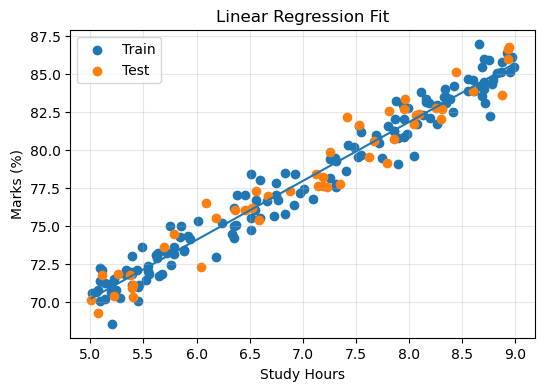

In [7]:
# Scatter with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train.flatten(), y_train, label='Train')
plt.scatter(X_test.flatten(), y_test, label='Test')

# Order X for a clean line
x_line = np.linspace(df_clean['study_hours'].min(), df_clean['study_hours'].max(), 100).reshape(-1,1)
y_line = lr.predict(x_line)
plt.plot(x_line, y_line)

plt.title('Linear Regression Fit')
plt.xlabel('Study Hours')
plt.ylabel('Marks (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Save Best Model + Metrics
We select the model with higher R² and export it for the Flask app. We also persist metrics and example predictions.

In [8]:
# Choose best model by R2
best_name, best_model, best_metrics = ('LinearRegression', lr, metrics_lr)
if metrics_dt['R2'] > metrics_lr['R2']:
    best_name, best_model, best_metrics = ('DecisionTree', dt, metrics_dt)

# Save model
joblib.dump(best_model, APP_MODEL_PATH)
print(f"Saved best model: {best_name} → {APP_MODEL_PATH}")  # ➤ model path

# Save metrics
metrics_payload = {
    'LinearRegression': metrics_lr,
    'DecisionTree': metrics_dt,
    'best_model': best_name
}
with open(RESULTS_DIR / 'metrics.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_payload, f, indent=2)
print('Metrics saved to', (RESULTS_DIR / 'metrics.json'))  # ➤ metrics path

# Save example predictions for quick reference
example_df = pd.DataFrame({
    'study_hours': X_test.flatten(),
    'true_marks': y_test,
    'pred_marks_lr': y_pred_lr,
    'pred_marks_dt': y_pred_dt
}).sort_values('study_hours')
example_df.to_csv(RESULTS_DIR / 'example_predictions.csv', index=False)
display(example_df.head())  # ➤ sample
print('Examples saved to', (RESULTS_DIR / 'example_predictions.csv'))

Saved best model: LinearRegression → C:\Users\MUBASSHIR\OneDrive\Desktop\FSDS_TASKS\Machine_Learning\ML_Projects\01_StudentScoreAI\app\student_mark_prediction.pkl
Metrics saved to C:\Users\MUBASSHIR\OneDrive\Desktop\FSDS_TASKS\Machine_Learning\ML_Projects\01_StudentScoreAI\results\metrics.json


,study_hours,true_marks,pred_marks_lr,pred_marks_dt
23,5.01,70.11,70.250267,70.580
22,5.07,69.27,70.482765,70.790
16,5.11,71.79,70.637763,72.080
35,5.22,70.40,71.064008,71.005
34,5.26,71.86,71.219006,70.270


Examples saved to C:\Users\MUBASSHIR\OneDrive\Desktop\FSDS_TASKS\Machine_Learning\ML_Projects\01_StudentScoreAI\results\example_predictions.csv


### Quick Inference Snippet (for sanity check)
Verify the exported model predicts sensibly for a sample input.

In [9]:
# Reload and test (e.g., 5.5 hours)
mdl = joblib.load(APP_MODEL_PATH)
test_hours = 5.5
pred = float(mdl.predict(np.array([[test_hours]])).item())
print(f'Hours={test_hours} → Predicted Marks ≈ {round(pred,2)}%')  # ➤ sample prediction

Hours=5.5 → Predicted Marks ≈ 72.15%


### Conclusion & Next Steps
- We built a compact, transparent regression workflow for predicting student marks from study hours.
- Outputs include an exported model for the Flask app and saved evaluation artifacts.
- **Next ideas:** add features (attendance, sleep, prior scores), try regularized linear models (Ridge/Lasso), cross-validation, and model monitoring in the app.